# Part 2 - Regression

## 2.1 Synthetic Dataset Generation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# input
# N - size of the sample
# f - the target function
# sigma = the standard deviation
#output: a noisy sample, where each ti = f(xi)+Normal(0,sigma)
def generateDataset(N, f, sigma):
    x = np.arange(0,1,1/N)
    t= f(x)
    noise = np.random.normal(0., sigma, N)
    i=0
    while i < len(t):
        t[i] = t[i] + noise[i]
        i+=1
    return x,t

Now we test our implemntation by ploting a graph for 
$f(x)=sin(2\pi x), \sigma= 0.05, N=100$

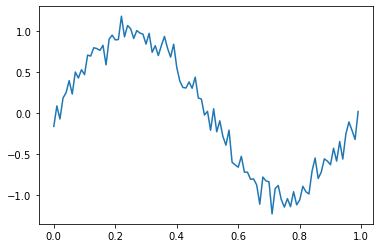

In [3]:
def f(x):
    return np.sin(2*np.pi*x)

x,t=generateDataset(100,f,0.1)
plt.plot(x,t)
plt.show()

## 2.2 Polynomial Curve Fitting



In [4]:
#input 
# x- vector nX1
# m - number > 0
#output - matrix nXm
def createMatrix(x,m):
    return np.array([[xi ** m for m in range(m + 1)] for xi in x])


def OptimizeLS(x, t, m):
    x = createMatrix(x,m)
    return np.dot(np.dot(np.linalg.pinv(np.dot(x.transpose(), x)),x.transpose()),t)

We want to minimize the function $E_{LS}(w) = \frac{1}{2} \sum\limits_{i} (Poly_w (x_i)-t_i)^2 $.
We first crate the matrix X from the data, using createMatrix(x,m).
Then we minimize $E_{LS}(w)$ by computing 
$$
w = (X^TX)^{-1} X^T t
$$

If X is singular, then we use its pseudo inverse

Now, we'll test OptimizeLS(x, t, m) on a dataset of size $N=10, f=sin(2\pi x), m=1,3,5,10$

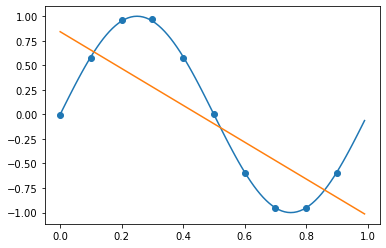

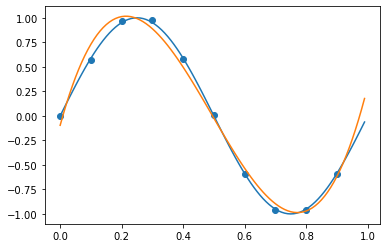

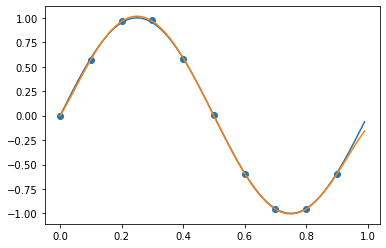

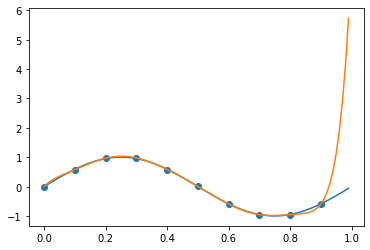

In [5]:
def vecAsPoly(x, w, m):
    sum = 0
    i = 0
    while i <= m:
        sum = sum + w[i]*pow(x,i)
        i+=1
    return sum


def plotF(f):
    r = np.arange(0,1,0.01)
    y = [f(x) for x in r]
    plt.plot(r,y)
    

def plotPoly(w,m):
    r = np.arange(0,1,0.01)
    y = [vecAsPoly(x, w, m) for x in r]
    plt.plot(r,y)
    

x,t=generateDataset(10,f,0.01)

for m in [1,3,5,10]:
    w = OptimizeLS(x, t, m)
    plotF(f)
    plotPoly(w,m)
    plt.scatter(x, t)
    plt.show()



The optimal result is achieved when m=5. 
When m=10 we there is an overfitting. 

## 2.3 Polynomial Curve Fitting with Regularization

First, we create the function optimizePLS(x, t, M, lambda), which returns the optimal parameters w given M and lambda. 
The new objective function also contains a rgularization component, in addition to squared errors:

$$
E_{PLS}(w) = \frac{1}{2} \sum\limits_{i} (Poly_w (x_i)-t_i)^2  + \frac{1}{2} \sum\limits_{m= 1... deg(Poly_w)} w_m^2
$$

In [6]:
def optimizePLS(x, t, m, lmda):
    X = createMatrix(x,m)
    return np.dot(np.dot(np.linalg.inv
                         (np.dot(X.transpose(),X)+(lmda*np.eye(m+1))),
                         X.transpose()),t)


We extend our synthetic dataset construction function to return 3 samples: one for training, one for development and one for testing.

In [7]:
def generateDataset3(N, f, sigma):
    x = np.linspace(0,1,3*N)
    np.random.shuffle(x)
    t= f(x)
    noise = np.random.normal(0., sigma, 3*N)
    i=0
    while i < len(t):
        t[i] = t[i] + noise[i]
        i+=1
    x1,t1 = x[0:N], t[0:N]
    x2,t2 = x[N:2*N], t[N:2*N]
    x3,t3 = x[2*N:3*N], t[2*N:3*N]
    return x1,t1,x2,t2,x3,t3

Finally, we added a function that computes the normalized error of the model:

In [8]:
def normalizedError(x,t,w,m):
    i=0
    sum = 0
    while i < len(x):
        polyVal = vecAsPoly(x[i], w, m)
        sum+=pow((t[i]-polyVal),2)
        i+=1
    return (1/len(x))*pow(sum,1/2)

Now, given a dataset, we can optimize the value of λ by varying the value of log(λ) from -40 to -20 on the development set.
The next function draws the plot of the normalized error of the model for the training, development and test for the case of N = 10 and m = 10 

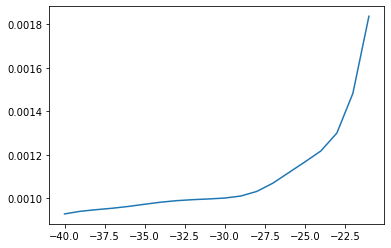

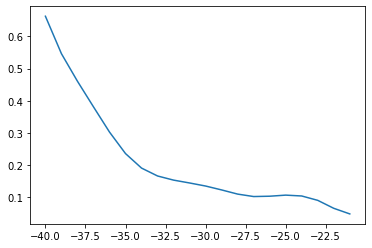

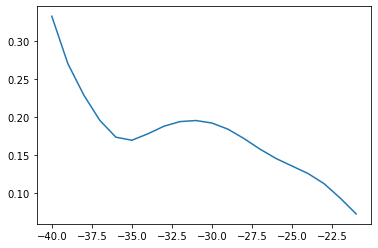

In [9]:
def getPlotForSet(x1,t1,x2,t2,m):
    errs = []
    r = range(-40, -20)
    for i in r:
        lamda = pow(2, i)
        w1 = optimizePLS(x1, t1, m, lamda)
        err = normalizedError(x2, t2, w1, m)
        errs.append(err)
    plt.plot(r, errs)
    plt.show()


x_train,t_train,x_val,t_val,x_test,t_test = generateDataset3(10,f,0.01)
m=10
getPlotForSet(x_train,t_train,x_train,t_train,m)
getPlotForSet(x_train,t_train,x_val,t_val,m)
getPlotForSet(x_train,t_train,x_test,t_test,m)

And now, for the case N=100

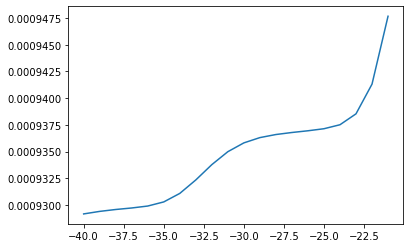

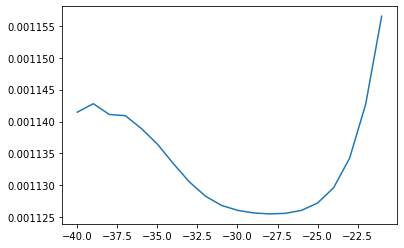

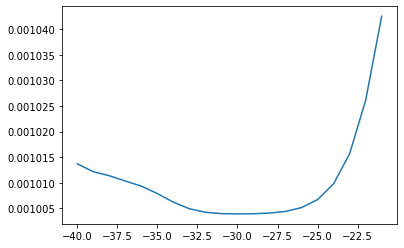

In [10]:
x_train,t_train,x_val,t_val,x_test,t_test = generateDataset3(100,f,0.01)
m=10
getPlotForSet(x_train,t_train,x_train,t_train,m)
getPlotForSet(x_train,t_train,x_val,t_val,m)
getPlotForSet(x_train,t_train,x_test,t_test,m)

In both cases, we see that the optimal $\lambda$ is around 27. We'll test this assumption using the function optimizeLambda(xt, tt, xv, tv, m)

In [11]:
def optimizeLambda(xt, tt, xv, tv, m):
    errs = []
    for i in range(-40, -20):
        lamda = pow(2, i)
        w=optimizePLS(xt,tt,m,lamda)
        err=normalizedError(xv,tv,w,m)
        errs.append(err)
    minIndex = errs.index(min(errs))
    return -40+minIndex

x_train,t_train,x_val,t_val,x_test,t_test = generateDataset3(100,f,0.01)
m=10
optimal_lambda = optimizeLambda(x_train,t_train,x_val,t_val,m)
print("The optimal value is: " +str(optimal_lambda))

The optimal value is: -23


To see it graphically, we'll plot $sin(2\pi x)$ and optimizePLS(x_train, t_train, 10, -27)

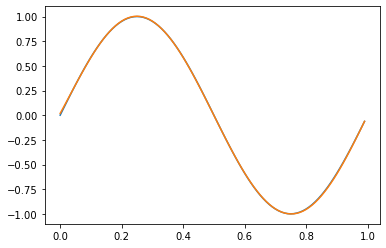

In [12]:
x_train,t_train,x_val,t_val,x_test,t_test = generateDataset3(100,f,0.01)
m=10
lamda = pow(2,-27)
w = optimizePLS(x_train, t_train, m, lamda)
plotF(f)
plotPoly(w,m)
plt.show()

## 2.4 Probabilistic Regression Framework

First, we implement the bayesianEstimator(x, t, M, alpha, sigma2), which given the dataset (x, t) of size N, and the parameters M, alpha, and sigma2, returns the functions m(x),var(x) which are the mean and variance of the predictive distribution inferred from the dataset. 

In [13]:
def getXasVec(x,m):
    return np.array([pow(x,i) for i in range(m+1)])

def sumMetrices(x,m):
    vecs = [getXasVec(xi,m) for xi in x]
    mats = [np.outer(v,v) for v in vecs]
    return sum(mats)

def bayesianEstimator(x, t, M, alpha, sigma2):
    Sinv= alpha*np.eye(M+1)+ (1/sigma2)*sumMetrices(x,M)
    S = np.linalg.inv(Sinv)

    def m(x1):
        xs = [getXasVec(xi,M) for xi in x]
        sumProducts = 0
        i=0
        while i < len(t):
            sumProducts+=np.dot(xs[i],t[i])
            i+=1
        return (1/sigma2)*np.dot(np.dot(getXasVec(x1,M).T,S),sumProducts)

    def var(x1):
        vx = getXasVec(x1,M)
        return sigma2 + np.dot(np.dot(vx.T,S),vx)

    return m,var

Now, given a dataset of size N=10 we'll draw a plot of the function $sin(2\pi x)$ over the range $[0,1]$ , the function m(x) and the confidence interval $(m(x) - var(x)^{1/2})$ and $(m(x) + var(x)^{1/2})$, for the values : 
alpha = 0.005,
sigma2 = 1/11.1,
M = 9

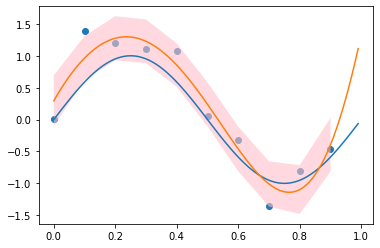

In [14]:
def plotConf(x, m, var):
    t = np.array([m(xi) for xi in x])
    varx = np.array([np.sqrt(var(xi)) for xi in x])
    plt.fill_between(x, t-varx, t+varx, facecolor='pink', alpha=0.6)

alpha = 0.005
sigma2 = 1/11.1
M = 9
N = 10
x, t = generateDataset(N, f, np.sqrt(sigma2))
m,var = bayesianEstimator(x, t, M, alpha, sigma2)
plotF(f)
plotF(m)
plt.scatter(x, t)
plotConf(x, m, var)
plt.show()

And now for the case N=100

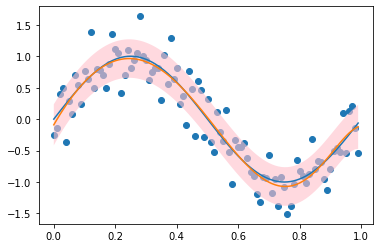

In [15]:
N = 100
x, t = generateDataset(N, f, np.sqrt(sigma2))
m,var = bayesianEstimator(x, t, M, alpha, sigma2)
plotF(f)
plotF(m)
plt.scatter(x, t)
plotConf(x, m, var)
plt.show()